### Descripción del proyecto
Rusty Bargain es un servicio de venta de coches de segunda mano que está desarrollando una app para atraer a nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial, especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.

#### A Rusty Bargain le interesa:

- La calidad de la predicción 
- La velocidad de la predicción 
- El tiempo requerido para el entrenamiento

#### Descripción de los datos

El dataset está almacenado en el archivo /datasets/car_data.csv. descargar dataset.

Características

- DateCrawled — fecha en la que se descargó el perfil de la base de datos
- VehicleType — tipo de carrocería del vehículo
- RegistrationYear — año de matriculación del vehículo
- Gearbox — tipo de caja de cambios
- Power — potencia (CV)
- Model — modelo del vehículo
- Mileage — kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
- RegistrationMonth — mes de matriculación del vehículo
- FuelType — tipo de combustible
- Brand — marca del vehículo
- NotRepaired — vehículo con o sin reparación
- DateCreated — fecha de creación del perfil
- NumberOfPictures — número de fotos del vehículo
- PostalCode — código postal del propietario del perfil (usuario)
- LastSeen — fecha de la última vez que el usuario estuvo activo

Objetivo

- Price — precio (en euros)

#### Cargamos los datos

In [1]:
# Importar librerías necesarias
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Importación de modelos y herramientas de validación
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error  
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Importación de modelos de boosting
import lightgbm as lgb
import xgboost as xgb

In [2]:
# Cargamos los datos
raw_car = pd.read_csv('../raw/car_data.csv')
raw_car.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
# Revisamos si tenemos valores duplicados
raw_car.duplicated().value_counts()

False    354107
True        262
Name: count, dtype: int64

In [4]:
# Eliminamos valores duplicados
raw_car.drop_duplicates(inplace=True)
raw_car.reset_index()
raw_car.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 354107 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354107 non-null  object
 1   Price              354107 non-null  int64 
 2   VehicleType        316623 non-null  object
 3   RegistrationYear   354107 non-null  int64 
 4   Gearbox            334277 non-null  object
 5   Power              354107 non-null  int64 
 6   Model              334406 non-null  object
 7   Mileage            354107 non-null  int64 
 8   RegistrationMonth  354107 non-null  int64 
 9   FuelType           321218 non-null  object
 10  Brand              354107 non-null  object
 11  NotRepaired        282962 non-null  object
 12  DateCreated        354107 non-null  object
 13  NumberOfPictures   354107 non-null  int64 
 14  PostalCode         354107 non-null  int64 
 15  LastSeen           354107 non-null  object
dtypes: int64(7), object(9)
me

In [5]:
(
    raw_car
    .isnull()
    .agg(['sum', lambda x: x.mean() * 100])
    .T
    .rename(columns={'<lambda>': 'ptc_NaN','sum': 'is_NaN'})    
)


,is_NaN,ptc_NaN
DateCrawled,0.0,0.000000
Price,0.0,0.000000
VehicleType,37484.0,10.585501
RegistrationYear,0.0,0.000000
Gearbox,19830.0,5.600002
Power,0.0,0.000000
Model,19701.0,5.563573
Mileage,0.0,0.000000
RegistrationMonth,0.0,0.000000
FuelType,32889.0,9.287871


<Figure size 500x400 with 0 Axes>

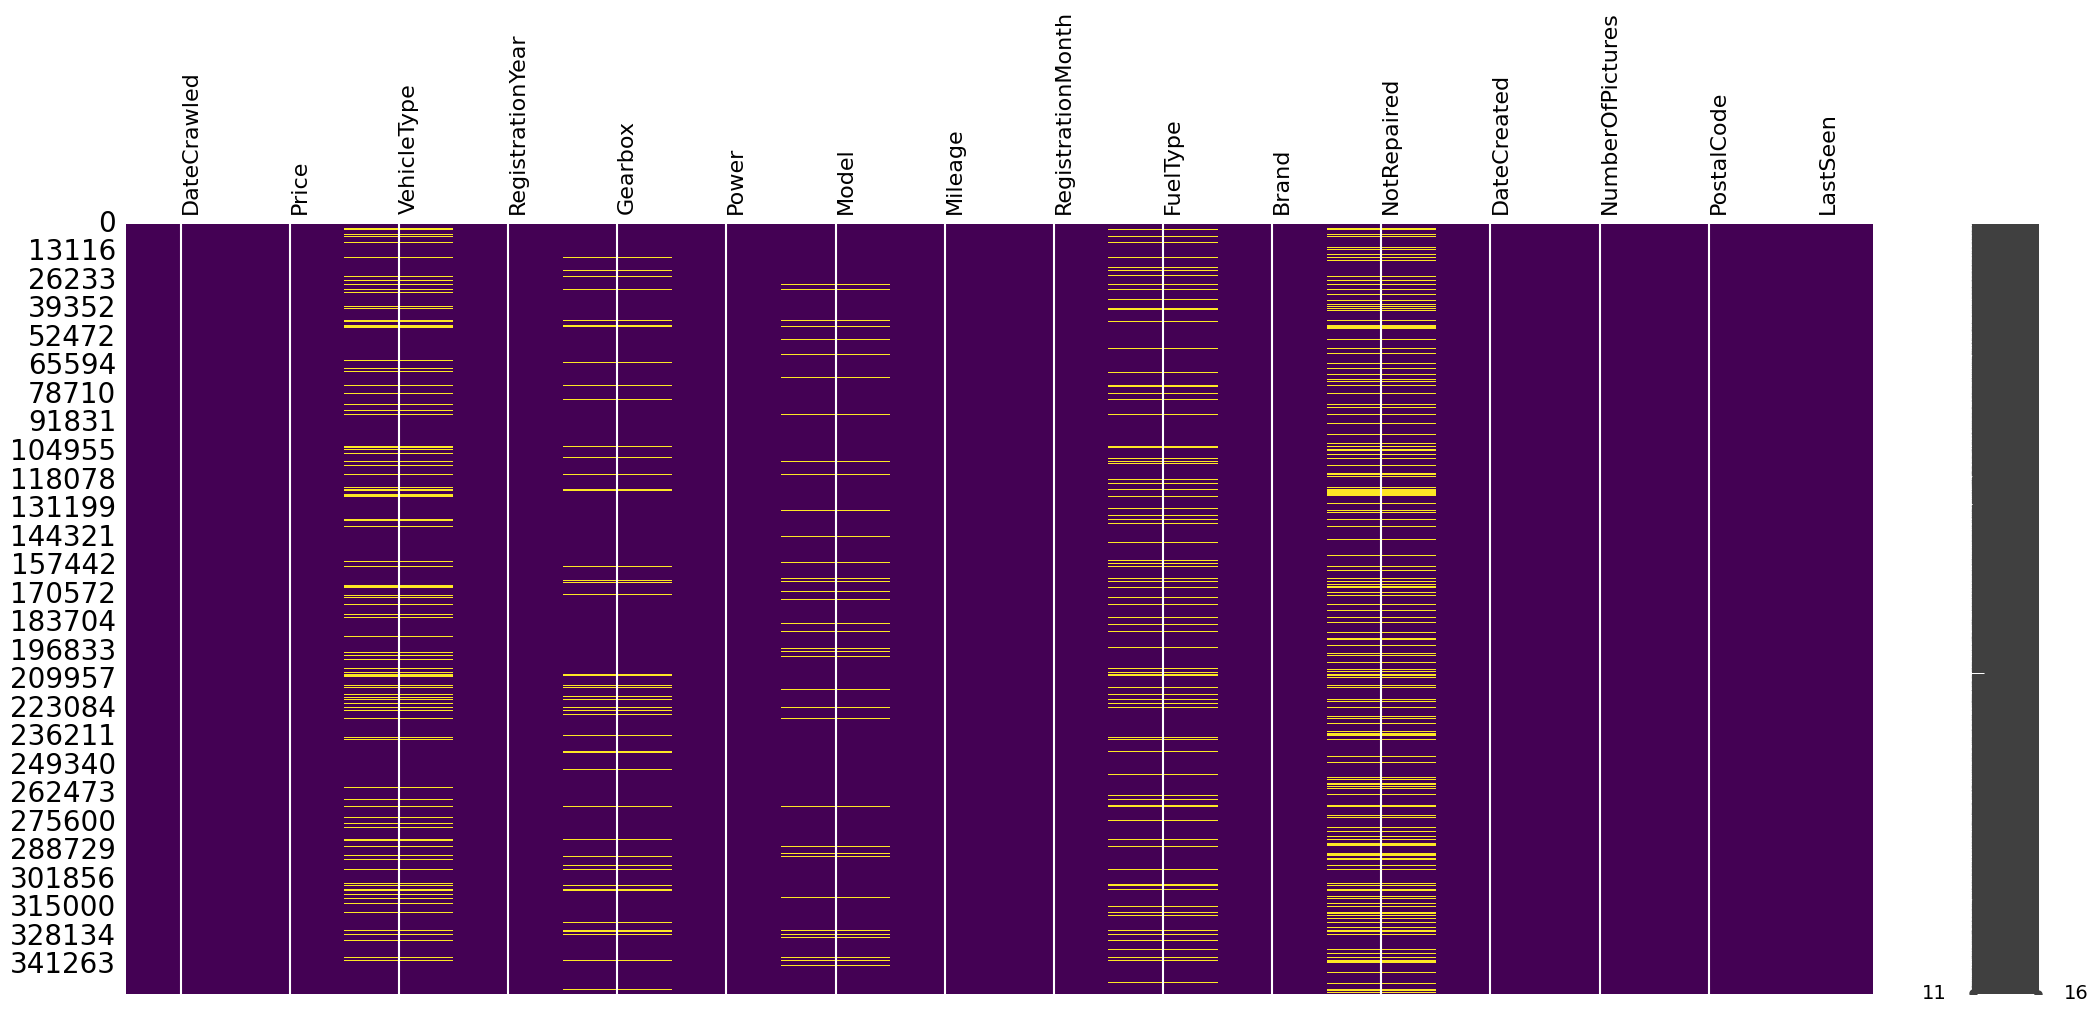

In [6]:
# Mostramos graficamente los valores faltantes.
plt.figure(figsize=(5, 4))
msno.matrix(raw_car)
sns.heatmap(raw_car.isna(), cbar=False, cmap="viridis")
plt.show()

<Figure size 500x400 with 0 Axes>

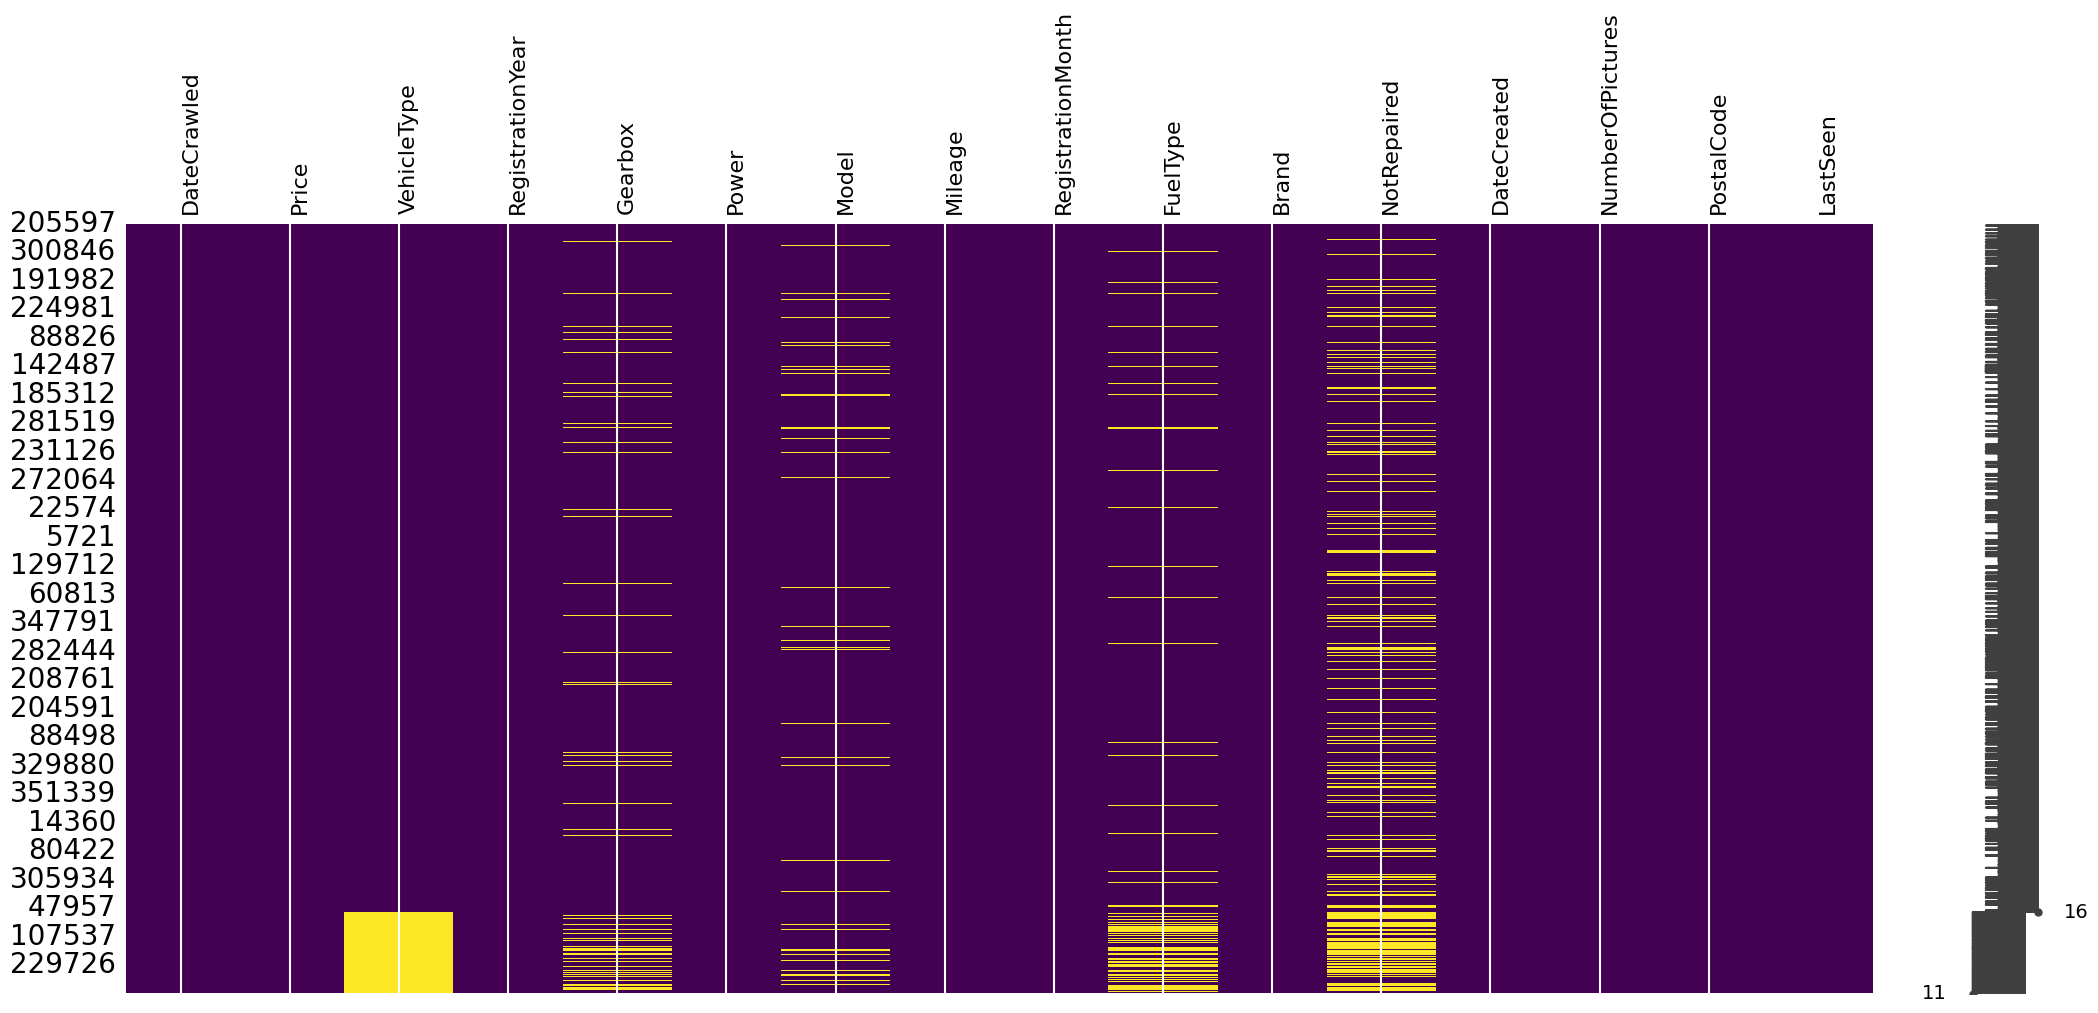

In [7]:
# Mostramos graficamente los valores faltantes. En funcion de 'VehicleType'
plt.figure(figsize=(5, 4))
raw_car_sorted = raw_car.sort_values(by='VehicleType', na_position='last')
msno.matrix(raw_car_sorted)
sns.heatmap(raw_car_sorted.isna(), cbar=False, cmap="viridis")
plt.show()

In [8]:
# Mostramos los valores para 'VehicleType'
raw_car['VehicleType'].value_counts(dropna=False)

VehicleType
sedan          91399
small          79753
wagon          65115
NaN            37484
bus            28752
convertible    20180
coupe          16147
suv            11991
other           3286
Name: count, dtype: int64

<Figure size 500x400 with 0 Axes>

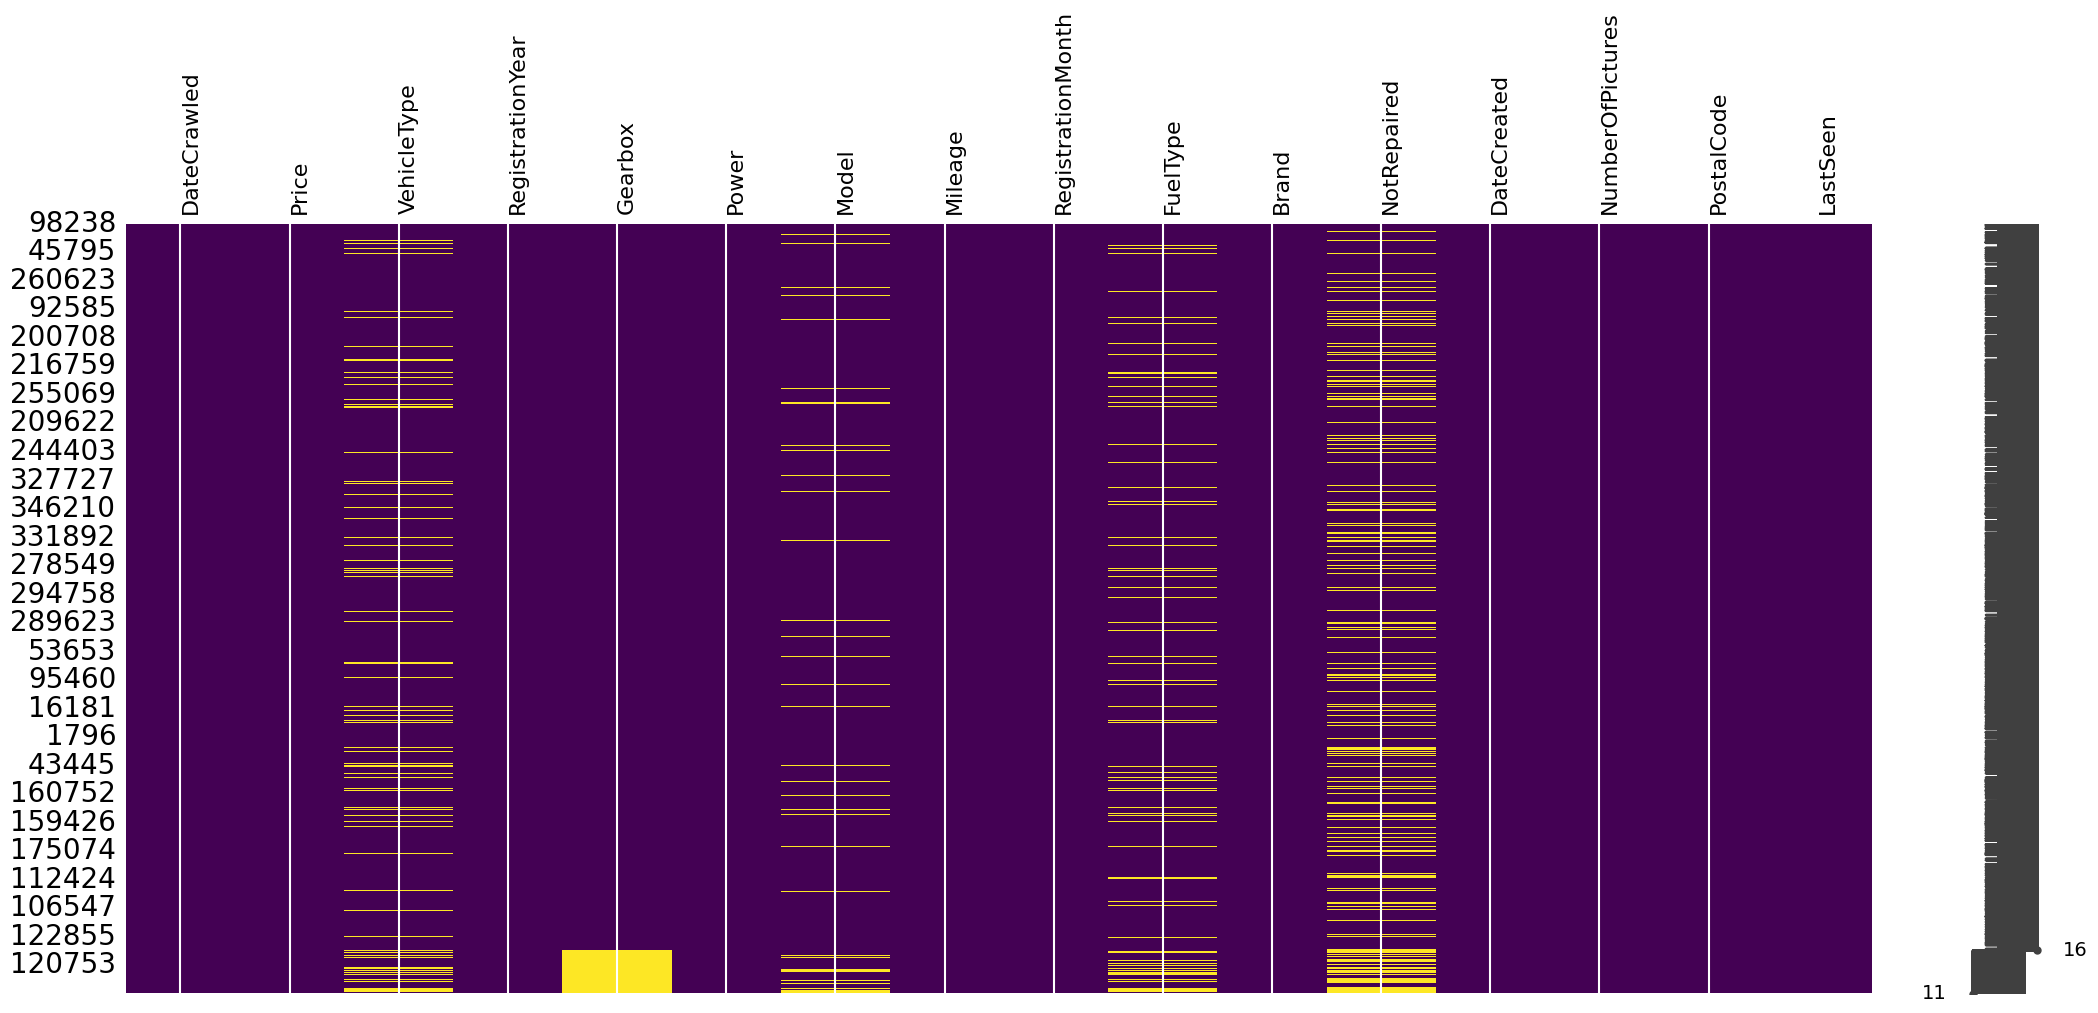

In [9]:
# Mostramos graficamente los valores faltantes. En funcion de 'Gearbox'
plt.figure(figsize=(5, 4))
raw_car_sorted = raw_car.sort_values(by='Gearbox', na_position='last')
msno.matrix(raw_car_sorted)
sns.heatmap(raw_car_sorted.isna(), cbar=False, cmap="viridis")
plt.show()

In [10]:
# Mostramos los valores para 'Gearbox'
raw_car['Gearbox'].value_counts(dropna=False)

Gearbox
manual    268034
auto       66243
NaN        19830
Name: count, dtype: int64

<Figure size 500x400 with 0 Axes>

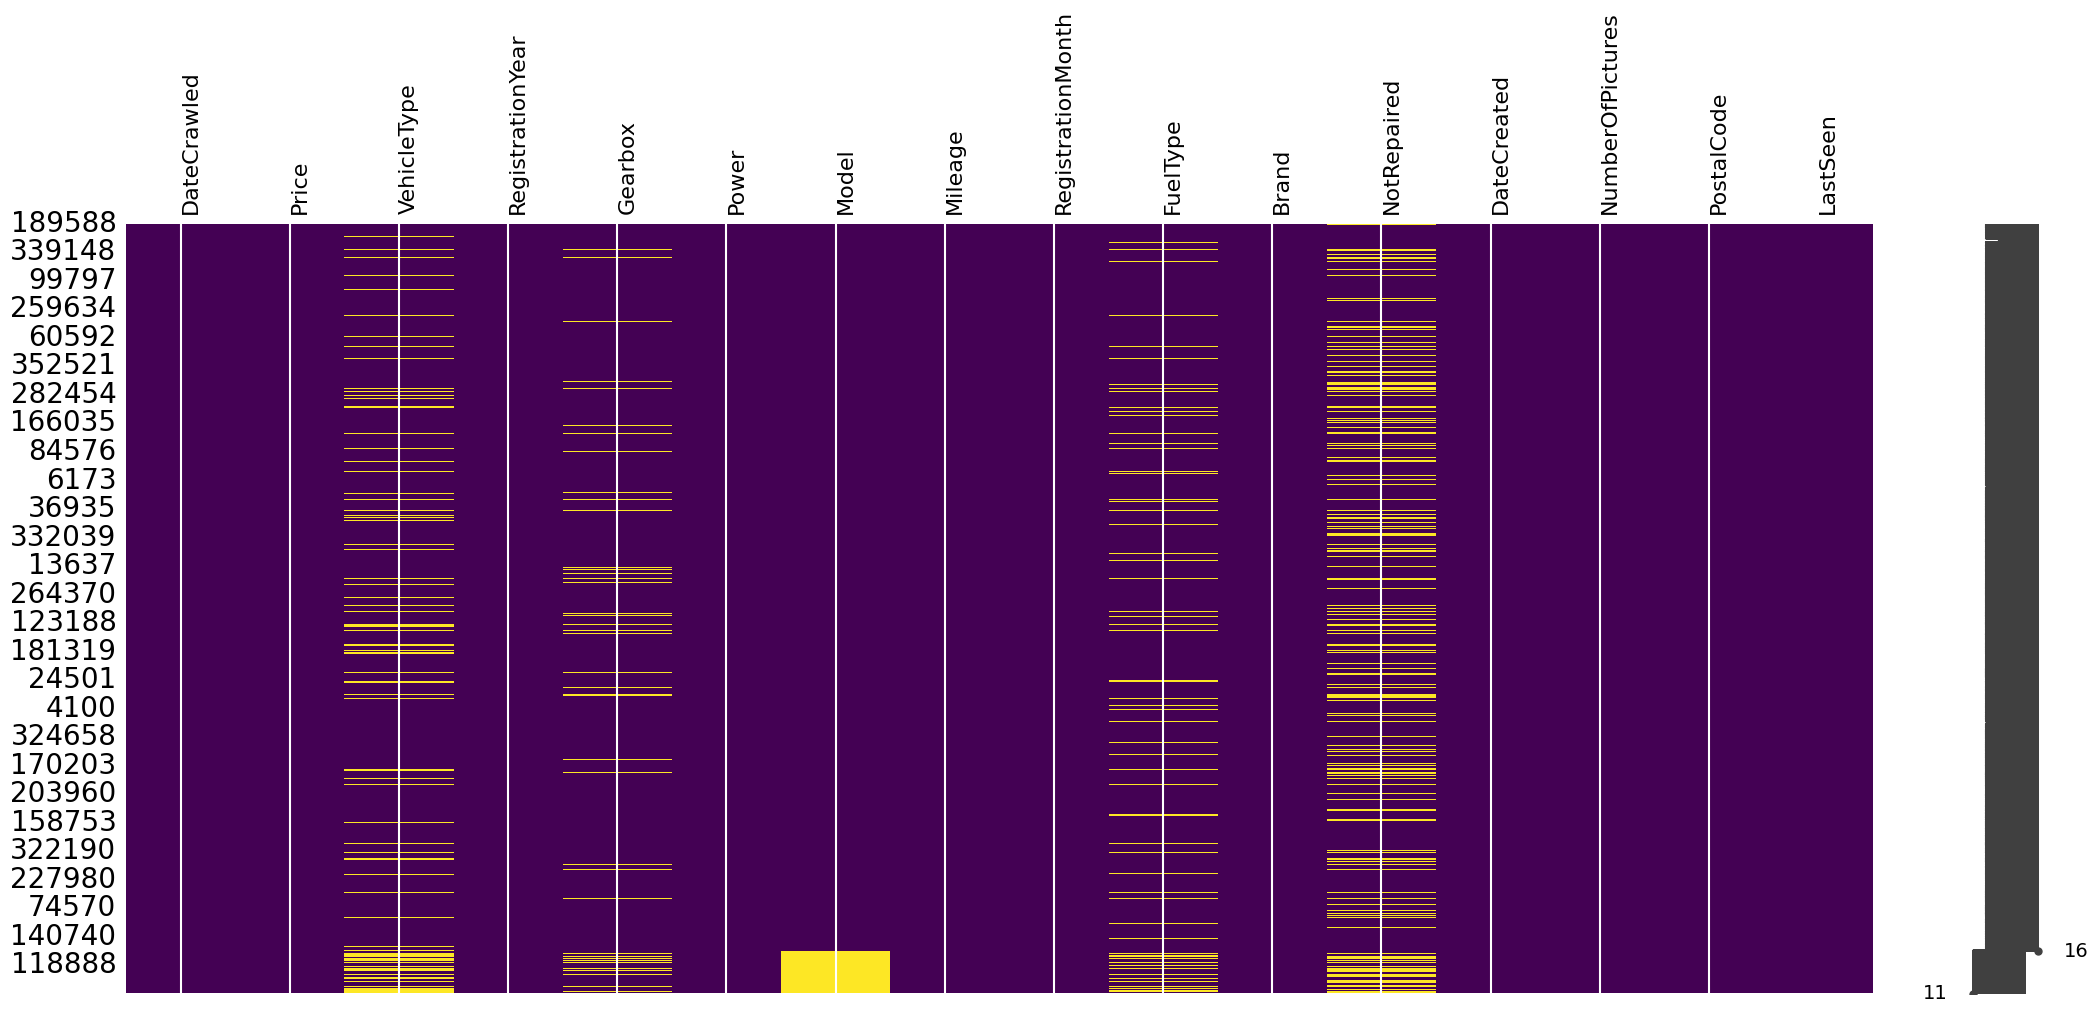

In [11]:
# Mostramos graficamente los valores faltantes. En funcion de 'Model'
plt.figure(figsize=(5, 4))
raw_car_sorted = raw_car.sort_values(by='Model', na_position='last')
msno.matrix(raw_car_sorted)
sns.heatmap(raw_car_sorted.isna(), cbar=False, cmap="viridis")
plt.show()

In [12]:
# Mostramos los valores para 'Model'
raw_car['Model'].value_counts(dropna=False)

Model
golf                  29215
other                 24402
3er                   19744
NaN                   19701
polo                  13057
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: count, Length: 251, dtype: int64

<Figure size 500x400 with 0 Axes>

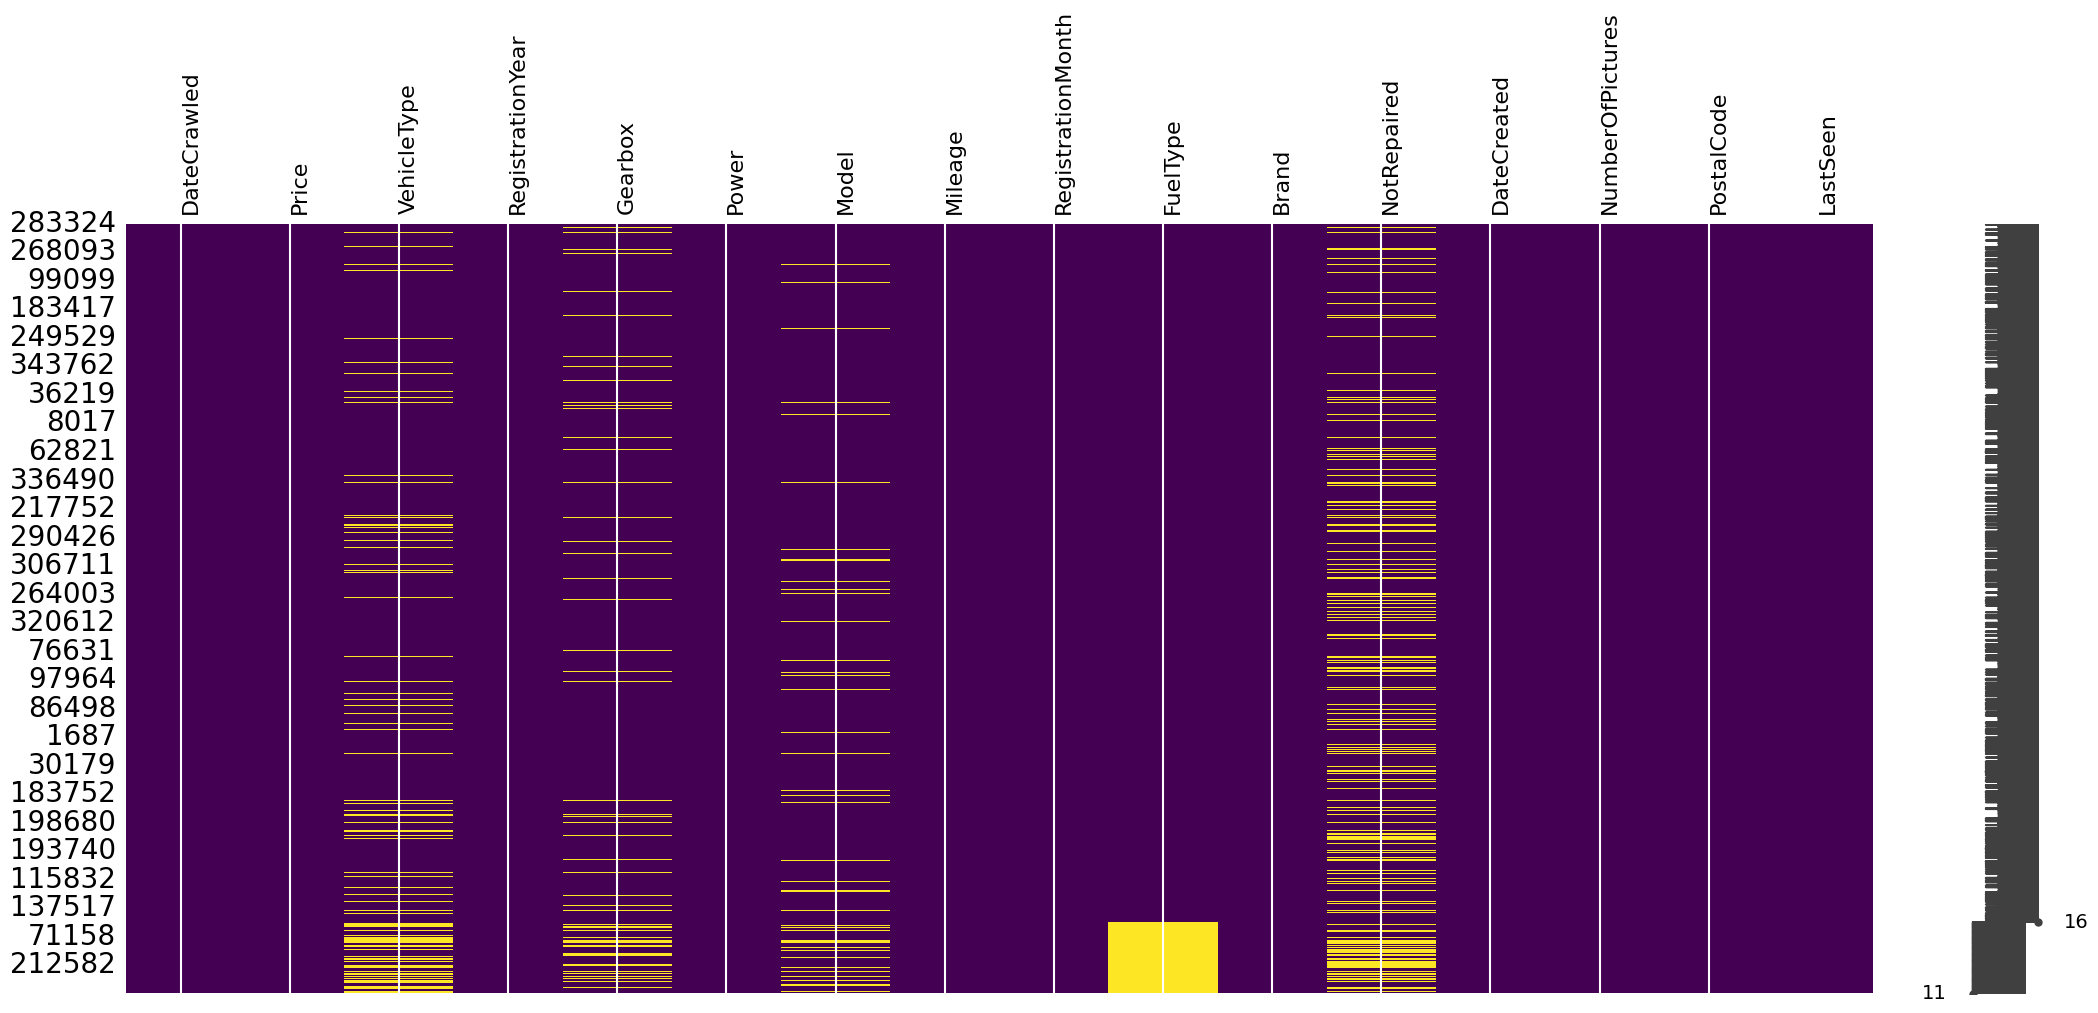

In [13]:
# Mostramos graficamente los valores faltantes. En funcion de 'FuelType'
plt.figure(figsize=(5, 4))
raw_car_sorted = raw_car.sort_values(by='FuelType', na_position='last')
msno.matrix(raw_car_sorted)
sns.heatmap(raw_car_sorted.isna(), cbar=False, cmap="viridis")
plt.show()

In [14]:
# Mostramos los valores para 'FuelType'
raw_car['FuelType'].value_counts(dropna=False)

FuelType
petrol      216161
gasoline     98658
NaN          32889
lpg           5307
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64

<Figure size 500x400 with 0 Axes>

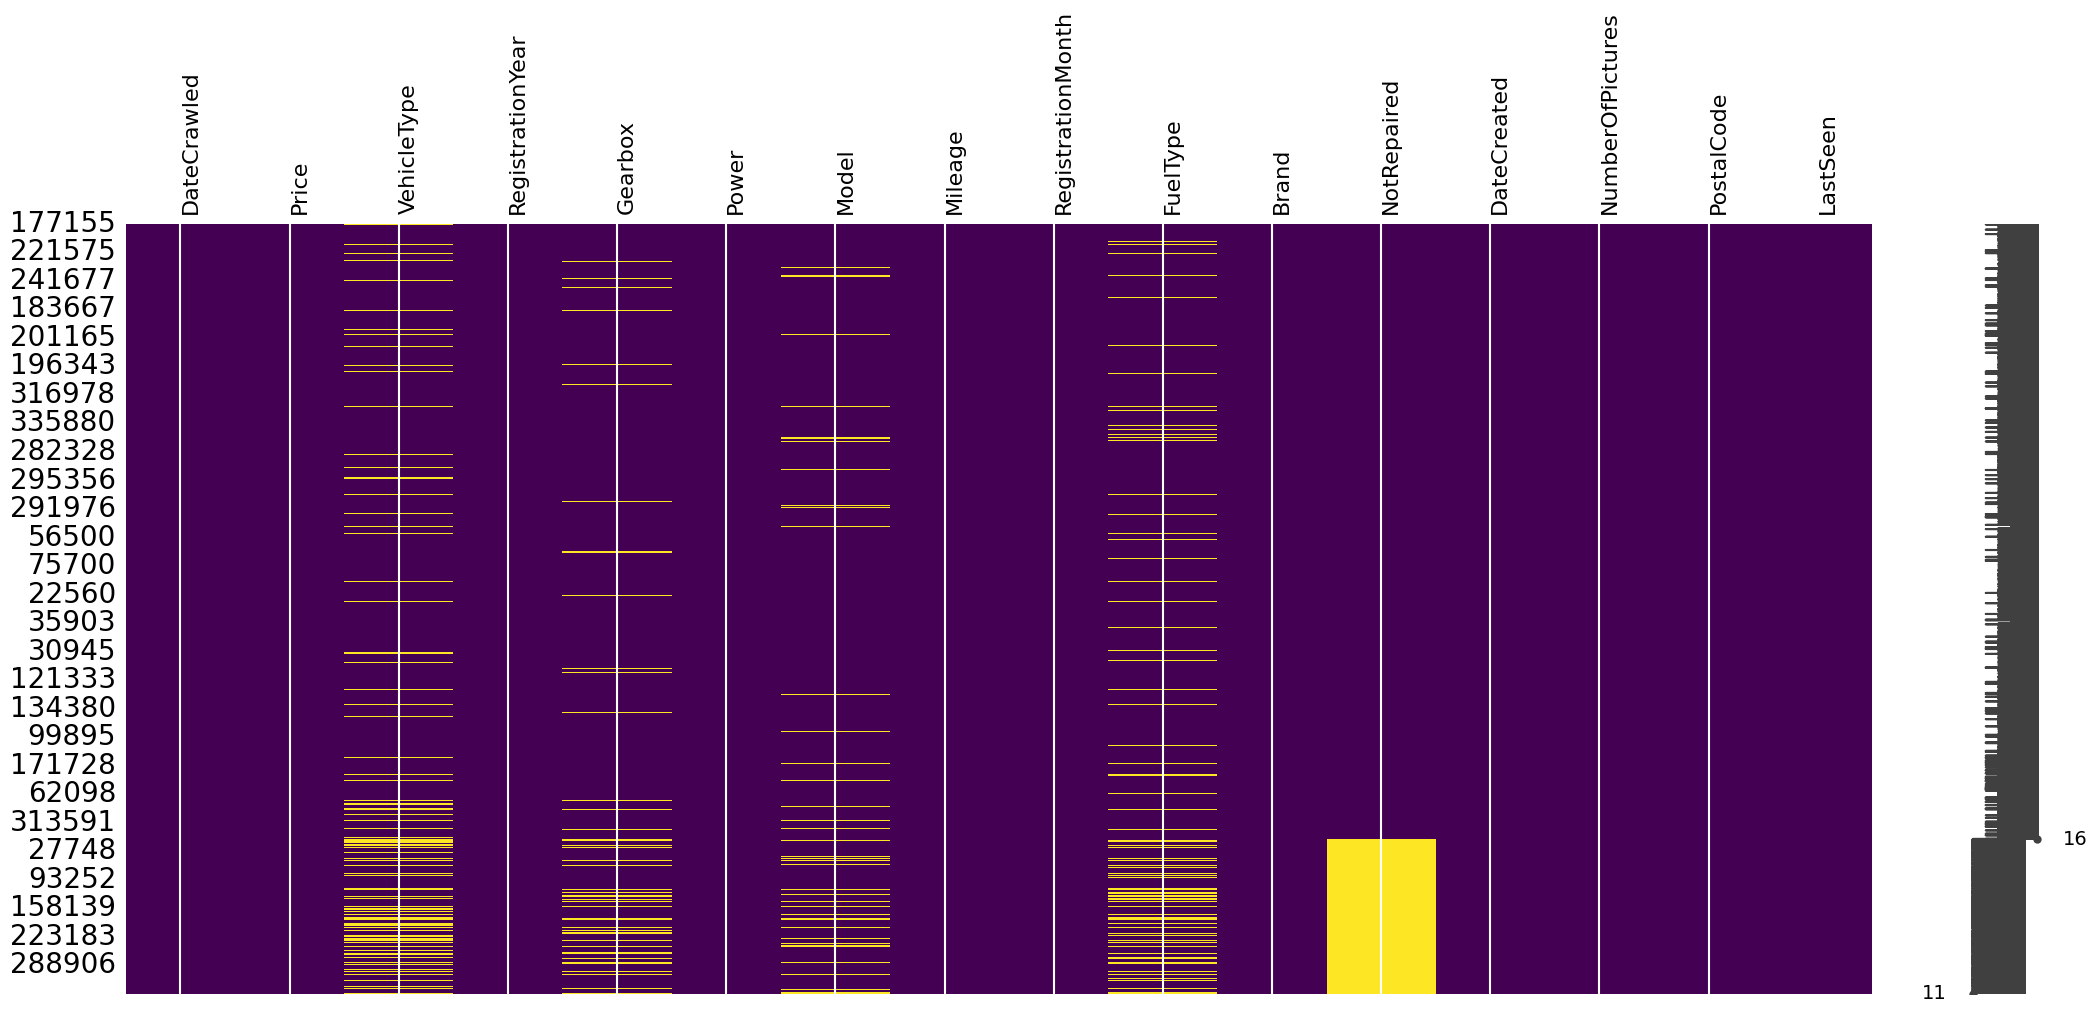

In [15]:
# Mostramos graficamente los valores faltantes. En funcion de 'NotRepaired'
plt.figure(figsize=(5, 4))
raw_car_sorted = raw_car.sort_values(by='NotRepaired', na_position='last')
msno.matrix(raw_car_sorted)
sns.heatmap(raw_car_sorted.isna(), cbar=False, cmap="viridis")
plt.show()

In [16]:
# Mostramos los valores para 'NotRepaired'
raw_car['NotRepaired'].value_counts(dropna=False)

NotRepaired
no     246927
NaN     71145
yes     36035
Name: count, dtype: int64

In [17]:
# Contamos los valores nulos por columna
nulos_por_columna = raw_car.isnull().sum()

# Filtramos las columnas que tienen valores nulos
nulos_por_columna = nulos_por_columna[nulos_por_columna >= 1]

# Ordenamos los resultados de mayor a menor
nulos_por_columna = nulos_por_columna.sort_values(ascending=False)

# Mostramos la cantidad de valores nulos por cada columna
nulos_por_columna

NotRepaired    71145
VehicleType    37484
FuelType       32889
Gearbox        19830
Model          19701
dtype: int64

In [ ]:
# Eliminamos los valores NaN de Not Repaired y luego eliminamos los registros que tengan al mas de 2 valores NAN en el mismo registro.

raw_car_NR = raw_car[raw_car['NotRepaired'].notna()]

raw_car_NR = raw_car_NR.dropna(axis=0, thresh=len(raw_car.columns)-2)

raw_car_NR.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 280984 entries, 1 to 354367
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        280984 non-null  object
 1   Price              280984 non-null  int64 
 2   VehicleType        265874 non-null  object
 3   RegistrationYear   280984 non-null  int64 
 4   Gearbox            274847 non-null  object
 5   Power              280984 non-null  int64 
 6   Model              271908 non-null  object
 7   Mileage            280984 non-null  int64 
 8   RegistrationMonth  280984 non-null  int64 
 9   FuelType           266474 non-null  object
 10  Brand              280984 non-null  object
 11  NotRepaired        280984 non-null  object
 12  DateCreated        280984 non-null  object
 13  NumberOfPictures   280984 non-null  int64 
 14  PostalCode         280984 non-null  int64 
 15  LastSeen           280984 non-null  object
dtypes: int64(7), object(9)
me

<Figure size 500x400 with 0 Axes>

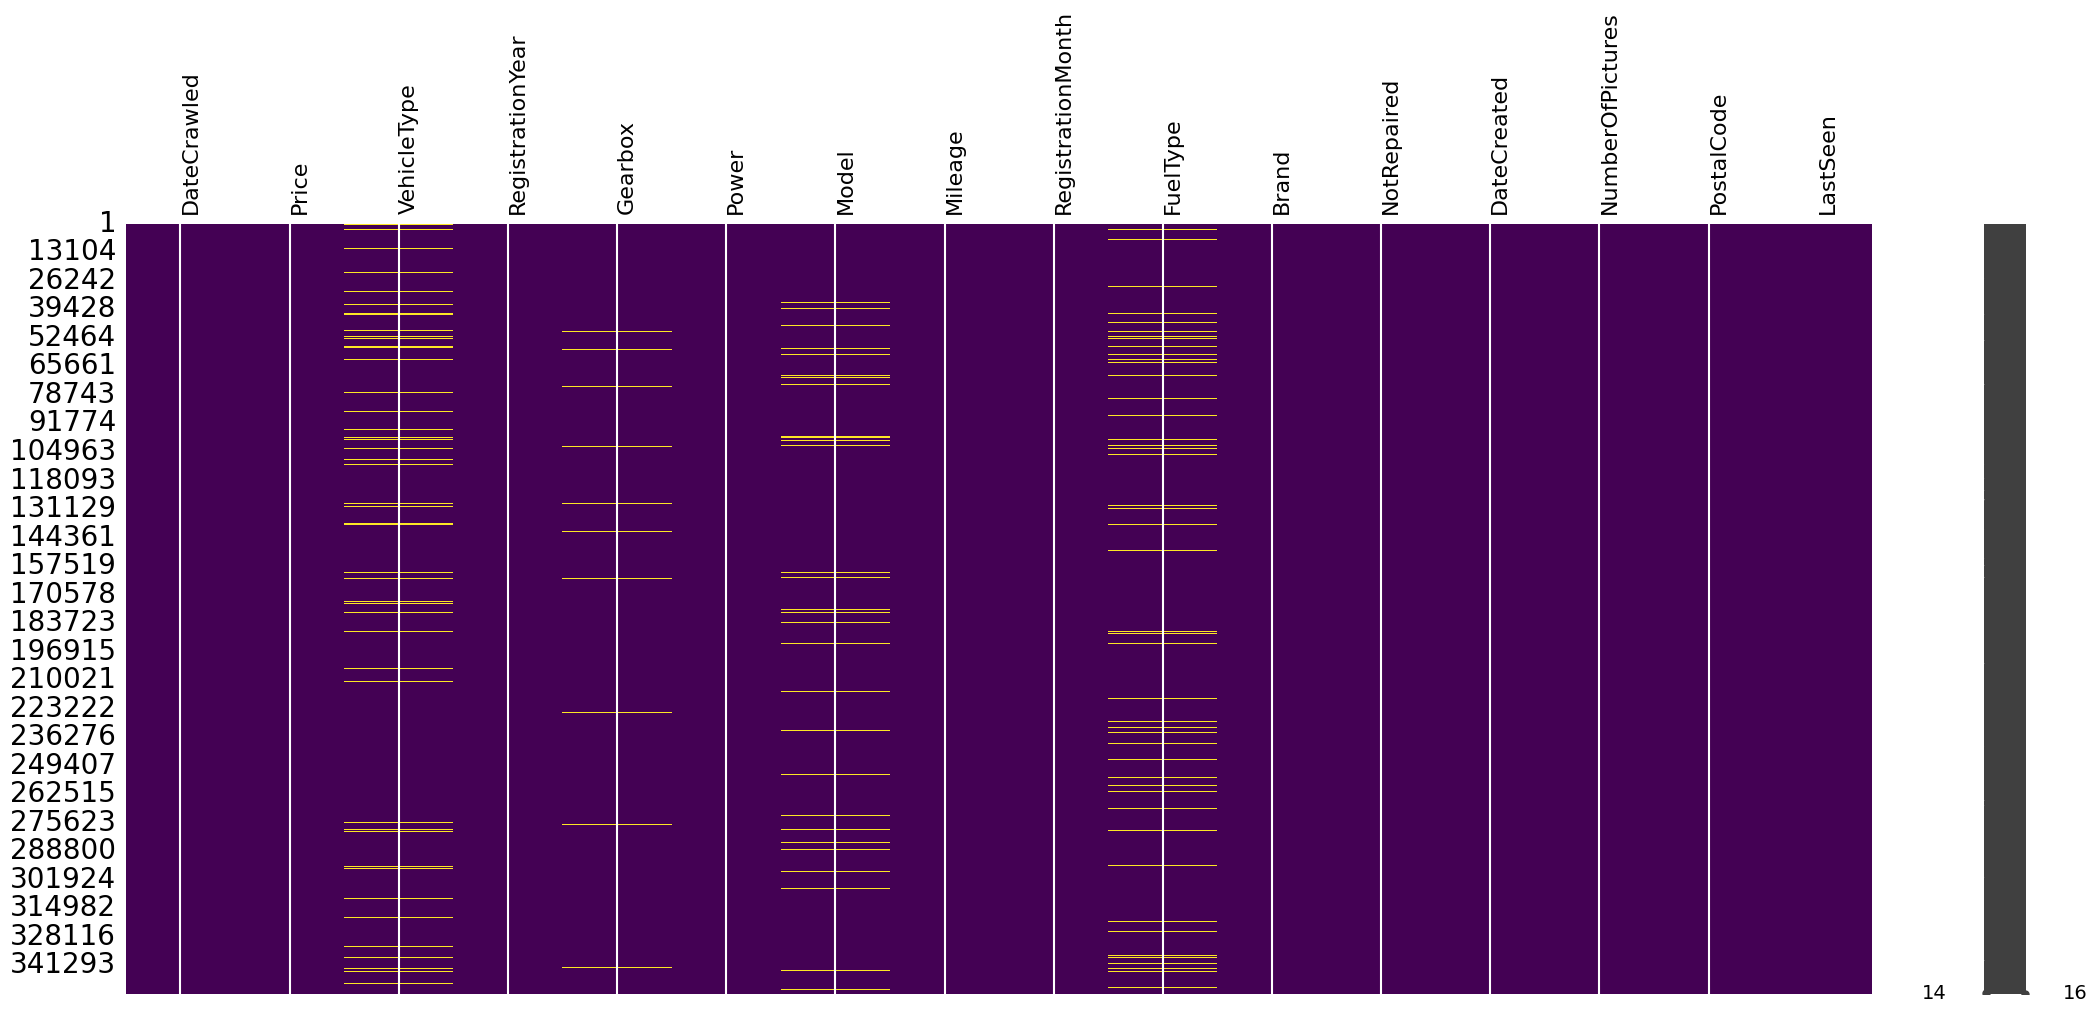

In [44]:
# Mostramos graficamente los valores faltantes. En funcion de 'NotRepaired'
plt.figure(figsize=(5, 4))
msno.matrix(raw_car_NR)
sns.heatmap(raw_car_NR.isna(), cbar=False, cmap="viridis")
plt.show()

In [45]:
# Completaremos los valores con la palabra 'Desconocido'.

raw_car_NR.fillna('Desconocido', inplace=True)
raw_car_NR.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 280984 entries, 1 to 354367
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        280984 non-null  object
 1   Price              280984 non-null  int64 
 2   VehicleType        280984 non-null  object
 3   RegistrationYear   280984 non-null  int64 
 4   Gearbox            280984 non-null  object
 5   Power              280984 non-null  int64 
 6   Model              280984 non-null  object
 7   Mileage            280984 non-null  int64 
 8   RegistrationMonth  280984 non-null  int64 
 9   FuelType           280984 non-null  object
 10  Brand              280984 non-null  object
 11  NotRepaired        280984 non-null  object
 12  DateCreated        280984 non-null  object
 13  NumberOfPictures   280984 non-null  int64 
 14  PostalCode         280984 non-null  int64 
 15  LastSeen           280984 non-null  object
dtypes: int64(7), object(9)
me

In [46]:
raw_car.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
150908,04/04/2016 18:47,14990,wagon,2007,auto,218,3er,125000,6,petrol,bmw,no,04/04/2016 00:00,0,74366,06/04/2016 20:48
284646,22/03/2016 08:50,600,NaN,2005,manual,0,3_reihe,150000,0,gasoline,peugeot,NaN,22/03/2016 00:00,0,46537,05/04/2016 19:17
102263,24/03/2016 11:52,500,NaN,1995,NaN,0,fiesta,50000,0,NaN,ford,NaN,24/03/2016 00:00,0,66763,07/04/2016 03:16
99184,25/03/2016 10:53,100,NaN,2016,NaN,0,NaN,5000,0,petrol,citroen,NaN,25/03/2016 00:00,0,86899,06/04/2016 10:45
193034,09/03/2016 17:42,0,small,2000,NaN,0,micra,5000,0,NaN,nissan,NaN,09/03/2016 00:00,0,58456,19/03/2016 20:20
30740,29/03/2016 19:25,3300,sedan,2003,manual,95,a_klasse,150000,2,gasoline,mercedes_benz,no,29/03/2016 00:00,0,60437,06/04/2016 07:45
155840,03/04/2016 15:55,1550,wagon,1999,manual,144,omega,150000,10,petrol,opel,yes,03/04/2016 00:00,0,57078,03/04/2016 15:55
221256,16/03/2016 11:57,4850,sedan,2000,auto,224,s_klasse,150000,5,petrol,mercedes_benz,yes,16/03/2016 00:00,0,41063,06/04/2016 06:16
172770,16/03/2016 21:48,1999,NaN,2018,manual,54,polo,150000,3,NaN,volkswagen,NaN,16/03/2016 00:00,0,96049,29/03/2016 02:45
180886,12/03/2016 01:57,2500,NaN,1999,manual,0,a3,150000,11,NaN,audi,NaN,12/03/2016 00:00,0,1239,05/04/2016 20:16


In [47]:
#Actualizamos los tipos de datos:

categorical_columns = ['VehicleType','Gearbox','FuelType','NotRepaired','Brand']
raw_car_NR[categorical_columns] = raw_car_NR[categorical_columns].astype('category')

datatime_column= ['DateCrawled', 'DateCreated','LastSeen']
raw_car_NR[datatime_column] = raw_car_NR[datatime_column].apply(lambda x: pd.to_datetime(x, format='%d/%m/%Y %H:%M'))

# Extraer los componentes de DateCrawled
raw_car_NR['DateCrawled_year'] = raw_car_NR['DateCrawled'].dt.year
raw_car_NR['DateCrawled_month'] = raw_car_NR['DateCrawled'].dt.month
raw_car_NR['DateCrawled_day'] = raw_car_NR['DateCrawled'].dt.day
raw_car_NR['DateCrawled_hour'] = raw_car_NR['DateCrawled'].dt.hour
raw_car_NR['DateCrawled_minute'] = raw_car_NR['DateCrawled'].dt.minute

# Extraer los componentes de DateCreated
raw_car_NR['DateCreated_year'] = raw_car_NR['DateCreated'].dt.year
raw_car_NR['DateCreated_month'] = raw_car_NR['DateCreated'].dt.month
raw_car_NR['DateCreated_day'] = raw_car_NR['DateCreated'].dt.day
raw_car_NR['DateCreated_hour'] = raw_car_NR['DateCreated'].dt.hour
raw_car_NR['DateCreated_minute'] = raw_car_NR['DateCreated'].dt.minute

# Extraer los componentes de LastSeen
raw_car_NR['LastSeen_year'] = raw_car_NR['LastSeen'].dt.year
raw_car_NR['LastSeen_month'] = raw_car_NR['LastSeen'].dt.month
raw_car_NR['LastSeen_day'] = raw_car_NR['LastSeen'].dt.day
raw_car_NR['LastSeen_hour'] = raw_car_NR['LastSeen'].dt.hour
raw_car_NR['LastSeen_minute'] = raw_car_NR['LastSeen'].dt.minute

# Eliminar las columnas originales de fechas
raw_car_NR.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1, inplace=True)

raw_car_NR.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 280984 entries, 1 to 354367
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   Price               280984 non-null  int64   
 1   VehicleType         280984 non-null  category
 2   RegistrationYear    280984 non-null  int64   
 3   Gearbox             280984 non-null  category
 4   Power               280984 non-null  int64   
 5   Model               280984 non-null  object  
 6   Mileage             280984 non-null  int64   
 7   RegistrationMonth   280984 non-null  int64   
 8   FuelType            280984 non-null  category
 9   Brand               280984 non-null  category
 10  NotRepaired         280984 non-null  category
 11  NumberOfPictures    280984 non-null  int64   
 12  PostalCode          280984 non-null  int64   
 13  DateCrawled_year    280984 non-null  int32   
 14  DateCrawled_month   280984 non-null  int32   
 15  DateCrawled_day     28

In [ ]:
#Columna Model analisis para aplicar One Hot Encoding
model_count = raw_car_NR['Model'].value_counts().sort_values(ascending=False)  #Demasiados Modelos de Carros
model_count[model_count >= 1000].count() 

np.int64(51)

In [50]:
#Columna Model asignamos a 'Otros' a todos los model que tengan menos de 1000 ocurrencias.
model_replace = model_count[model_count < 1000].index
raw_car_NR['Model'] = raw_car_NR['Model'].replace(model_replace, 'Otros')
raw_car_NR['Model'] = raw_car_NR['Model'].astype('category')
raw_car_NR['Model'].value_counts().count()

np.int64(52)

#### Analisis de Datos

In [51]:
# Con los datos ya procesados asignamos un nuevo Dataframe para continuar con el analisis.
data = raw_car_NR.reset_index().drop('index', axis=1).copy(deep=True)
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280984 entries, 0 to 280983
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   Price               280984 non-null  int64   
 1   VehicleType         280984 non-null  category
 2   RegistrationYear    280984 non-null  int64   
 3   Gearbox             280984 non-null  category
 4   Power               280984 non-null  int64   
 5   Model               280984 non-null  category
 6   Mileage             280984 non-null  int64   
 7   RegistrationMonth   280984 non-null  int64   
 8   FuelType            280984 non-null  category
 9   Brand               280984 non-null  category
 10  NotRepaired         280984 non-null  category
 11  NumberOfPictures    280984 non-null  int64   
 12  PostalCode          280984 non-null  int64   
 13  DateCrawled_year    280984 non-null  int32   
 14  DateCrawled_month   280984 non-null  int32   
 15  DateCrawled_day  

In [52]:
#Verificamos antes de  usar One Hot Encoding
categorical_columns = data.select_dtypes('category').columns

for column in categorical_columns:
    print(f"Columna {column} tiene {data[column].nunique()} categorías únicas.")

Columna VehicleType tiene 9 categorías únicas.
Columna Gearbox tiene 3 categorías únicas.
Columna Model tiene 52 categorías únicas.
Columna FuelType tiene 8 categorías únicas.
Columna Brand tiene 40 categorías únicas.
Columna NotRepaired tiene 2 categorías únicas.


In [53]:
#Aplicamos One Hot Encoding y verificamos cantidad de columnas.
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
new_columns = data_encoded.columns.difference(data.columns)
data_encoded[new_columns] = data_encoded[new_columns].astype(int)

print(f"El conjunto de datos ahora tiene {data_encoded.shape[1]} columnas.")

El conjunto de datos ahora tiene 130 columnas.


In [54]:
# Dividimos en Caracteristicas y Objetivos
features = data_encoded.drop('Price',axis=1)
target = data_encoded['Price']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=42)

#### Entrena diferentes modelos con varios hiperparámetros (debes hacer al menos dos modelos diferentes, pero más es mejor. Recuerda, varias implementaciones de potenciación del gradiente no cuentan como modelos diferentes). El punto principal de este paso es comparar métodos de potenciación del gradiente con bosque aleatorio, árbol de decisión y regresión lineal.

In [55]:
# Función para calcular RMSE (Root Mean Squared Error)
def rmse(y_true, y_pred):
    """
    Calcula el Error Cuadrático Medio (RMSE) entre las predicciones y los valores reales.

    Parámetros:
    y_true (array-like): Valores reales.
    y_pred (array-like): Valores predichos.

    Retorna:
    float: El valor de RMSE.
    
    Levanta:
    ValueError: Si las dimensiones de y_true y y_pred no coinciden.
    """
    # Comprobar que las entradas son arrays de numpy y tienen la misma longitud
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if y_true.shape != y_pred.shape:
        raise ValueError("Las dimensiones de y_true y y_pred deben ser iguales.")
    
    # Calcular RMSE
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [56]:
# Valores maximo y minimo.
print(f'Para el target tenemos valor maximo {target.max()} y valor minimo {target.min()}')

Para el target tenemos valor maximo 20000 y valor minimo 0


In [ ]:
#Entrenamiento del modelo Regresion Lineal

# Modelo de Regresión Lineal
start_time = time.time()  # Iniciamos el temporizador

# Creamos y entrenamos el modelo
linear_model = LinearRegression()
linear_model.fit(features_train, target_train)

# Realizamos la predicción
target_pred_linear = linear_model.predict(features_valid)

# Calculamos el RMSE
rmse_linear = rmse(target_valid, target_pred_linear)

# Calculamos el tiempo de ejecución
lr_time = time.time() - start_time

# Imprimimos los resultados
print(f"RMSE para Regresión Lineal: {rmse_linear:.4f}")
print(f"Tiempo de ejecución de Regresión Lineal: {lr_time:.4f} segundos")

RMSE para Regresión Lineal: 3224.0941
Tiempo de ejecución de Regresión Lineal: 2.5139 segundos


In [ ]:
#Entrenamiento del modelo Arbol de Desicion

# Modelo de Árbol de Decisión
start_time = time.time()  # Iniciamos el temporizador

# Creamos y entrenamos el modelo
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(features_train, target_train)

# Realizamos la predicción
y_pred_dt = dt_model.predict(features_valid)

# Calculamos el RMSE
rmse_dt = rmse(target_valid, y_pred_dt)

# Calculamos el tiempo de ejecución
dt_time = time.time() - start_time

# Imprimimos los resultados
print(f"RMSE para Árbol de Decisión: {rmse_dt:.4f}")
print(f"Tiempo de ejecución de Árbol de Decisión: {dt_time:.4f} segundos")

RMSE para Árbol de Decisión: 2407.6807
Tiempo de ejecución de Árbol de Decisión: 5.4965 segundos


In [59]:
#Entrenamiento del modelo Bosque Aleatorio

# Modelo de Bosque Aleatorio con ajuste de hiperparámetros
start_time = time.time()  # Iniciamos el temporizador

# Creamos el modelo de Bosque Aleatorio
rf_model = RandomForestRegressor(random_state=42)

# Definimos los hiperparámetros para la búsqueda en cuadrícula
param_grid_rf = {
    'n_estimators': [10, 50],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

# Realizamos la búsqueda de hiperparámetros utilizando GridSearchCV
grid_rf = GridSearchCV(rf_model, param_grid_rf, cv=3, scoring='neg_mean_squared_error')
grid_rf.fit(features_train, target_train)

# Realizamos la predicción con el mejor modelo encontrado
y_pred_rf = grid_rf.best_estimator_.predict(features_valid)

# Calculamos el RMSE
rmse_rf = rmse(target_valid, y_pred_rf)

# Calculamos el tiempo de ejecución
rf_time = time.time() - start_time

# Imprimimos los resultados
print(f"RMSE para Bosque Aleatorio: {rmse_rf:.4f}")
print(f"Tiempo de ejecución de Bosque Aleatorio: {rf_time:.4f} segundos")

RMSE para Bosque Aleatorio: 1742.3210
Tiempo de ejecución de Bosque Aleatorio: 1048.4091 segundos


In [60]:
#Entrenamiento del modelo LigthGBM

# Modelo LightGBM
start_time = time.time()  # Iniciamos el temporizador

# Creamos y entrenamos el modelo LightGBM
lgb_model = lgb.LGBMRegressor(random_state=42, n_estimators=100, learning_rate=0.1, force_row_wise=True)
lgb_model.fit(features_train, target_train)

# Realizamos la predicción
y_pred_lgb = lgb_model.predict(features_valid)

# Calculamos el RMSE
rmse_lgb = rmse(target_valid, y_pred_lgb)

# Calculamos el tiempo de ejecución
lgb_time = time.time() - start_time

# Imprimimos los resultados
print(f"RMSE para LightGBM: {rmse_lgb:.4f}")
print(f"Tiempo de ejecución de LightGBM: {lgb_time:.4f} segundos")

[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 210738, number of used features: 123
[LightGBM] [Info] Start training from score 4888.484469
RMSE para LightGBM: 1771.5073
Tiempo de ejecución de LightGBM: 2.3664 segundos


In [61]:
#Entrenamiento del modelo XGBoost

# Modelo XGBoost
start_time = time.time()  # Iniciamos el temporizador

# Creamos y entrenamos el modelo XGBoost
xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
xgb_model.fit(features_train, target_train)

# Realizamos la predicción
y_pred_xgb = xgb_model.predict(features_valid)

# Calculamos el RMSE
rmse_xgb = rmse(target_valid, y_pred_xgb)

# Calculamos el tiempo de ejecución
xgb_time = time.time() - start_time

# Imprimimos los resultados
print(f"RMSE para XGBoost: {rmse_xgb:.4f}")
print(f"Tiempo de ejecución de XGBoost: {xgb_time:.4f} segundos")

RMSE para XGBoost: 1788.0814
Tiempo de ejecución de XGBoost: 5.0303 segundos


#### Analiza la velocidad y la calidad de los modelos.

In [63]:

# Índices de los modelos
model_names = ['Regresión Lineal', 'Árbol de Decisión', 'Bosque Aleatorio', 'LightGBM', 'XGBoost']

# Resultados de RMSE y tiempos
rmse_values = [rmse_linear, rmse_dt, rmse_rf, rmse_lgb, rmse_xgb] 
execution_times = [lr_time, dt_time, rf_time, lgb_time, xgb_time]

# Creamos el DataFrame directamente
df_results = pd.DataFrame({
    'RMSE': rmse_values,
    'Time': execution_times
}, index=model_names)

# Calculamos la relación calidad-tiempo
df_results['Quality_Time_Ratio'] = df_results['RMSE'] / df_results['Time']

# Mostramos el DataFrame con los resultados
df_results

,RMSE,Time,Quality_Time_Ratio
Regresión Lineal,3224.094055,2.513917,1282.497983
Árbol de Decisión,2407.680705,5.496545,438.035288
Bosque Aleatorio,1742.321035,1048.409143,1.661871
LightGBM,1771.507302,2.366401,748.608260
XGBoost,1788.081356,5.030321,355.460695


In [64]:
# La calidad la analizaremos con RMSE
df_results.sort_values('RMSE')

,RMSE,Time,Quality_Time_Ratio
Bosque Aleatorio,1742.321035,1048.409143,1.661871
LightGBM,1771.507302,2.366401,748.608260
XGBoost,1788.081356,5.030321,355.460695
Árbol de Decisión,2407.680705,5.496545,438.035288
Regresión Lineal,3224.094055,2.513917,1282.497983


In [66]:
# La velocidad la analizaremos con Time
df_results.sort_values('Time')

,RMSE,Time,Quality_Time_Ratio
LightGBM,1771.507302,2.366401,748.608260
Regresión Lineal,3224.094055,2.513917,1282.497983
XGBoost,1788.081356,5.030321,355.460695
Árbol de Decisión,2407.680705,5.496545,438.035288
Bosque Aleatorio,1742.321035,1048.409143,1.661871


In [67]:
# La velocidad la analizaremos con Time
df_results.sort_values('Quality_Time_Ratio')

,RMSE,Time,Quality_Time_Ratio
Bosque Aleatorio,1742.321035,1048.409143,1.661871
XGBoost,1788.081356,5.030321,355.460695
Árbol de Decisión,2407.680705,5.496545,438.035288
LightGBM,1771.507302,2.366401,748.608260
Regresión Lineal,3224.094055,2.513917,1282.497983


#### Conclusiones

- Vemos que el modelo mas rapido es el modelo 'LightGBM'.
- Vemos que el modelo que nos ofrece mayor calidad es 'Bosque Aleatorio' 
- En este caso para satisfacer el pedido del cliente usaria en primer lugar el modelo 'LightGBM' que es el mas cercano a cumplir con los deseos del cliente.
- Si bien es cierto el modelo Bosque Aleatorio es el que ofrece mayor calidad, demora 1048 seg.